[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\v-collinstoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\v-collinstoo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(0, '0.087*"gift" + 0.083*"card" + 0.055*"amazon" + 0.015*"kindle"')
(1, '0.197*"great" + 0.042*"idea" + 0.033*"gift" + 0.022*"pleased"')
(2, '0.046*"good" + 0.037*"product" + 0.033*"happy" + 0.029*"thank"')
(3, '0.106*"easy" + 0.092*"gift" + 0.046*"way" + 0.029*"card"')
(4, '0.026*"day" + 0.023*"time" + 0.021*"card" + 0.017*"mail"')


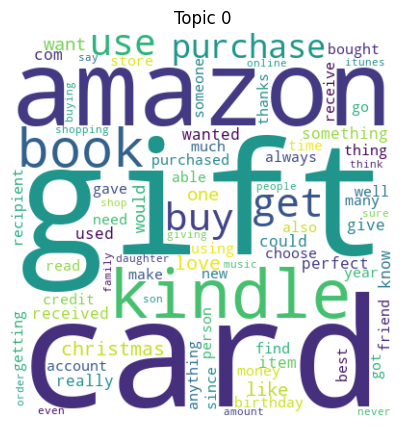

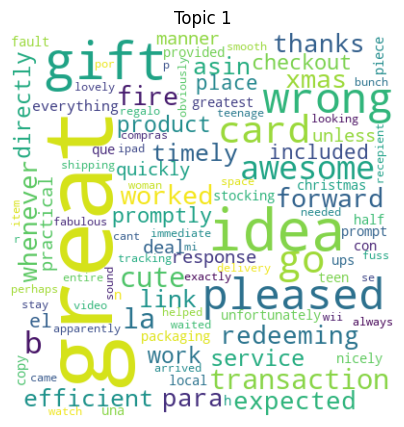

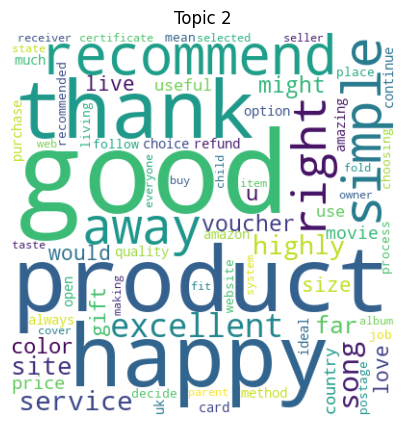

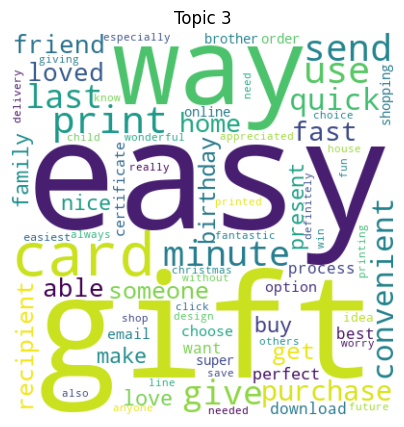

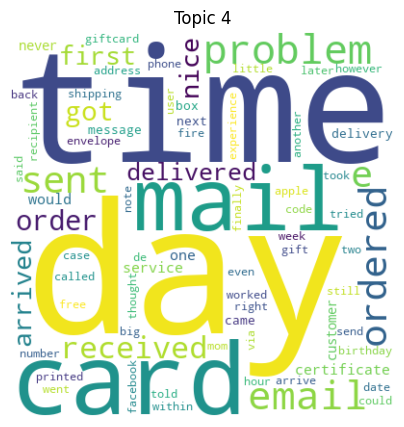

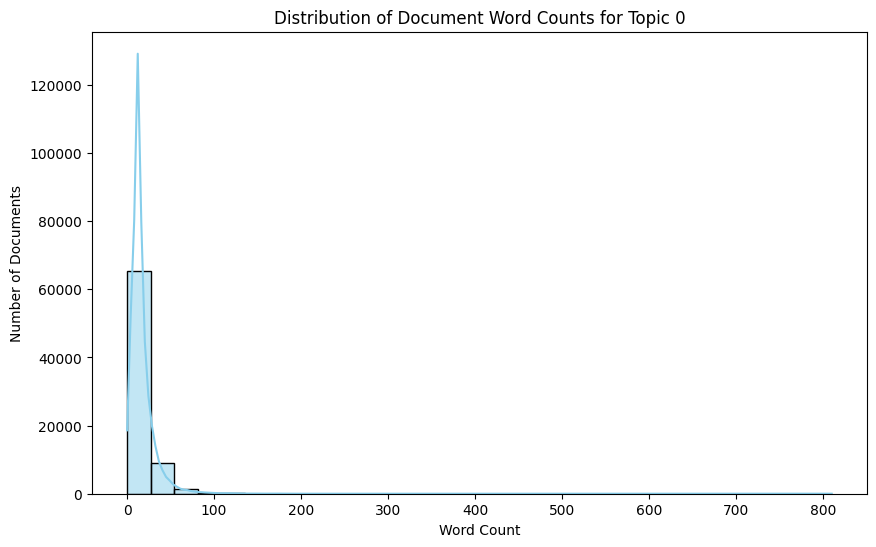

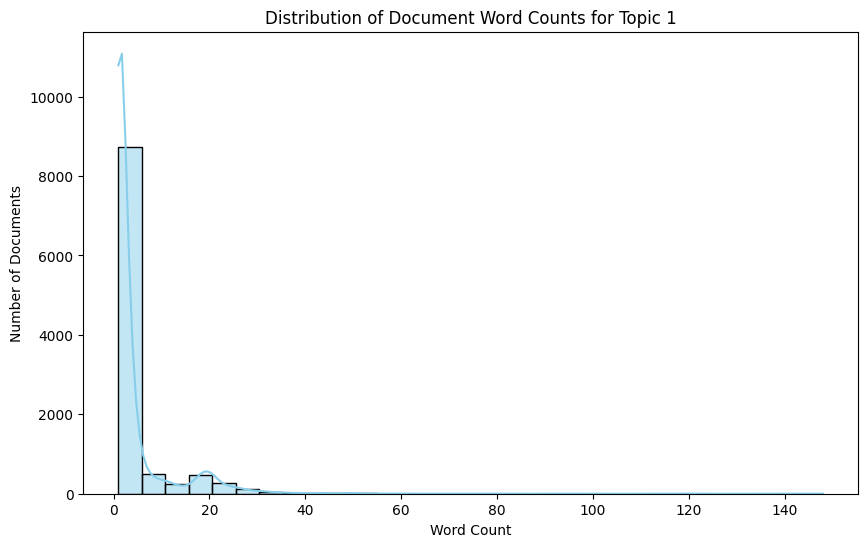

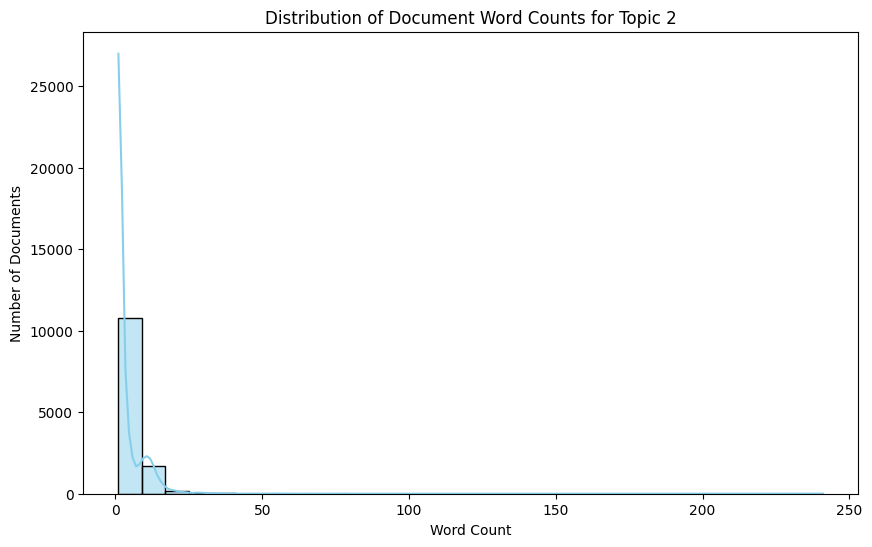

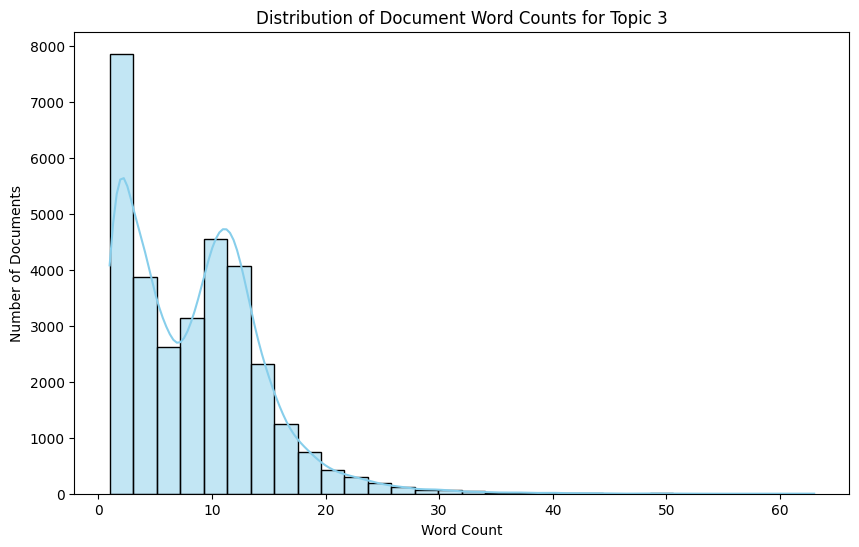

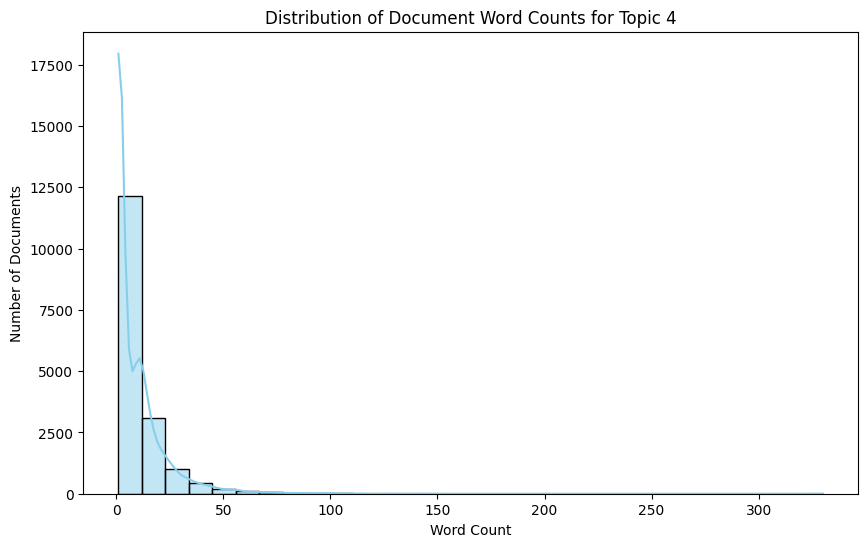

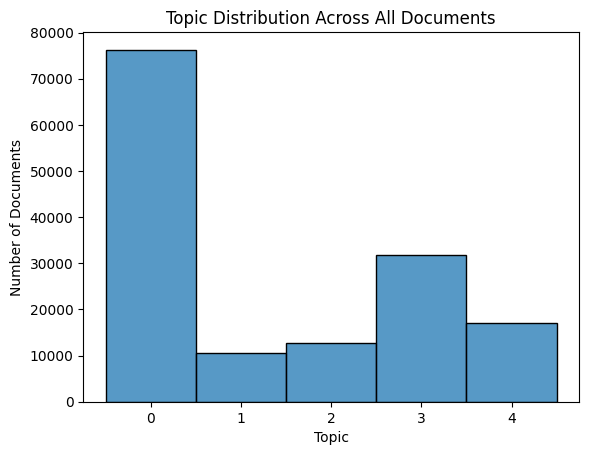

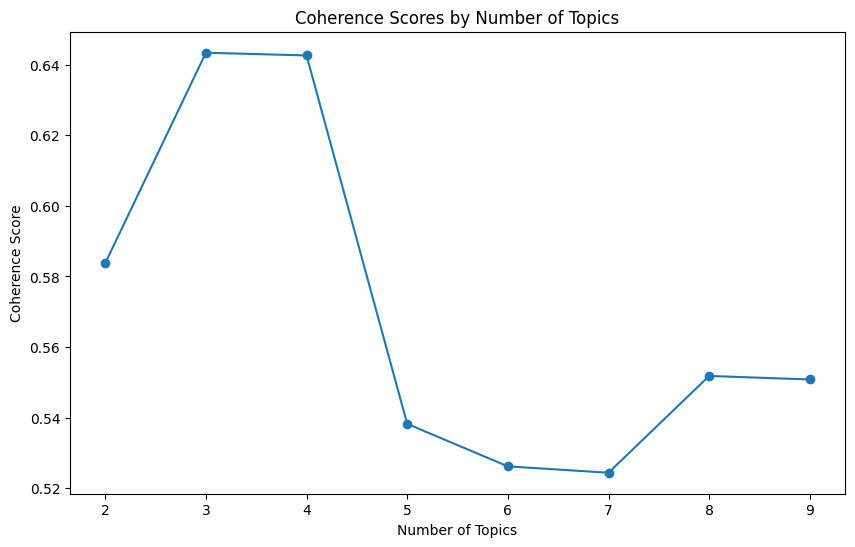

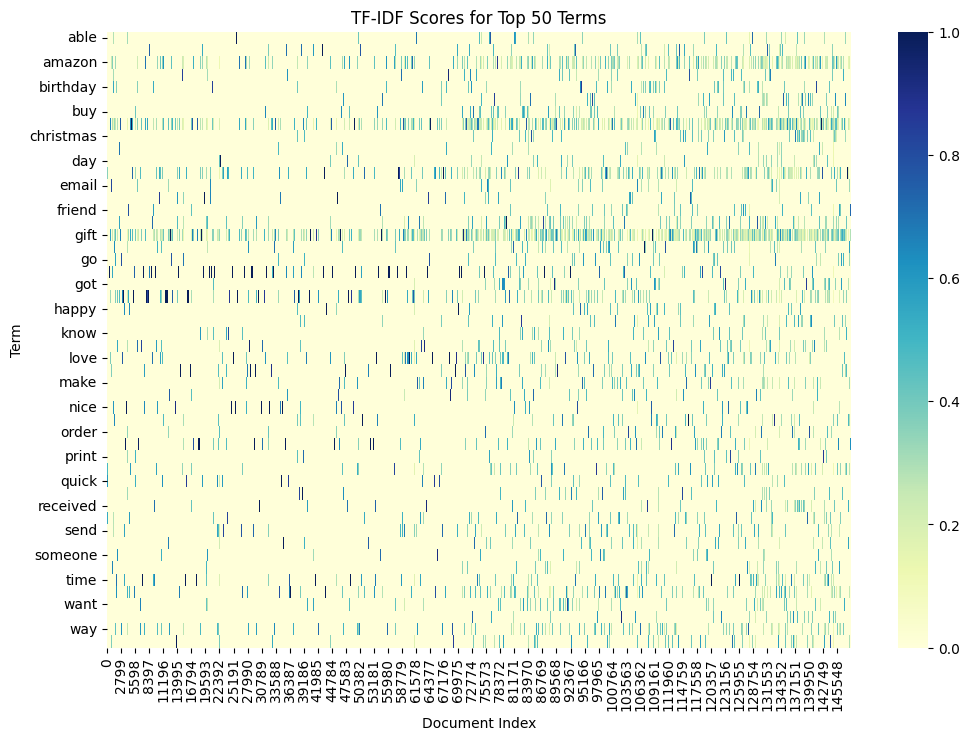

C:\Users\v-collinstoo\AppData\Local\Temp\ipykernel_5044\4048692238.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette='viridis')


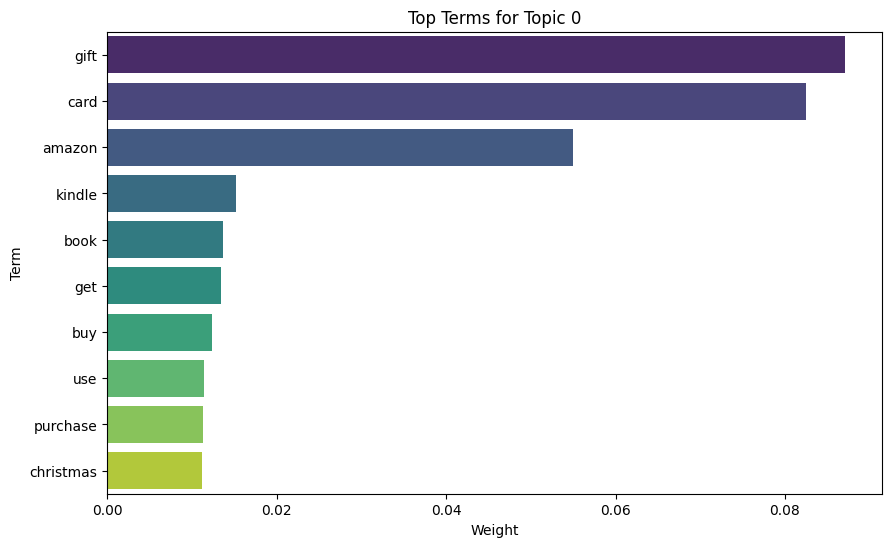

C:\Users\v-collinstoo\AppData\Local\Temp\ipykernel_5044\4048692238.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette='viridis')


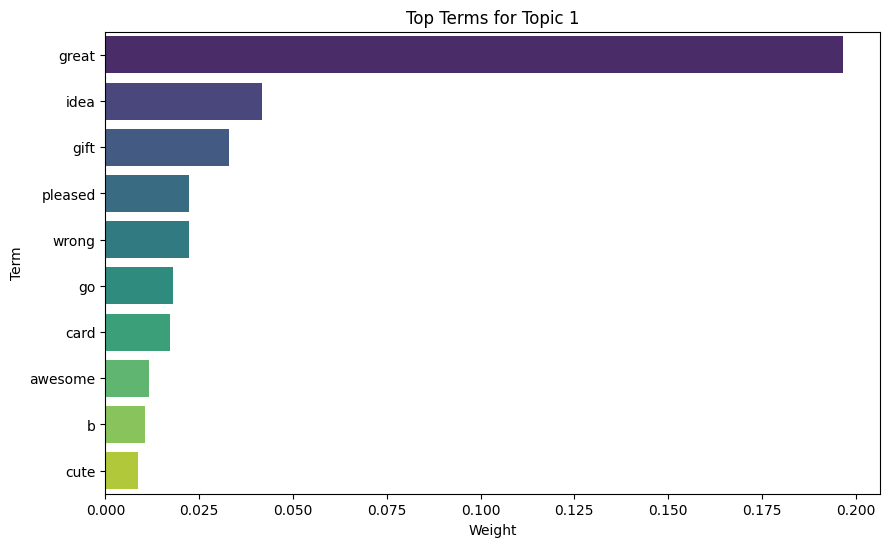

C:\Users\v-collinstoo\AppData\Local\Temp\ipykernel_5044\4048692238.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette='viridis')


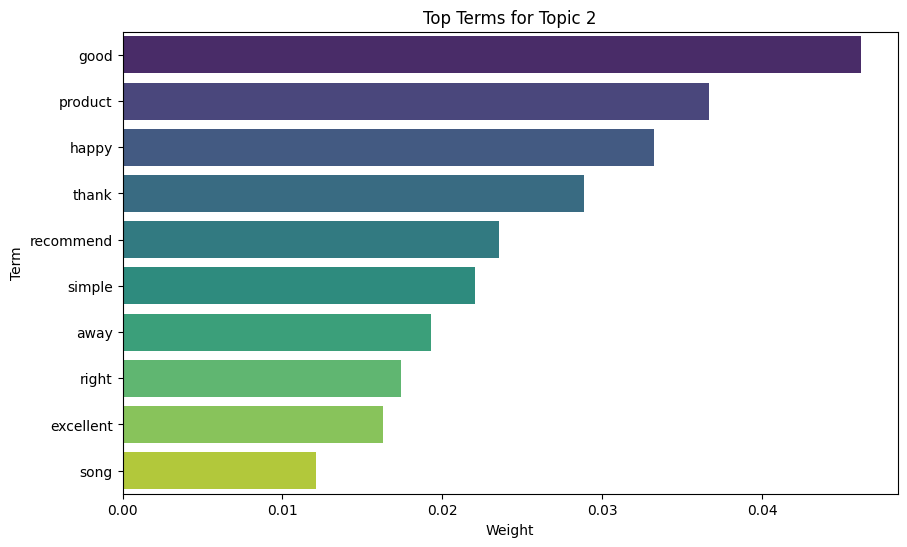

C:\Users\v-collinstoo\AppData\Local\Temp\ipykernel_5044\4048692238.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette='viridis')


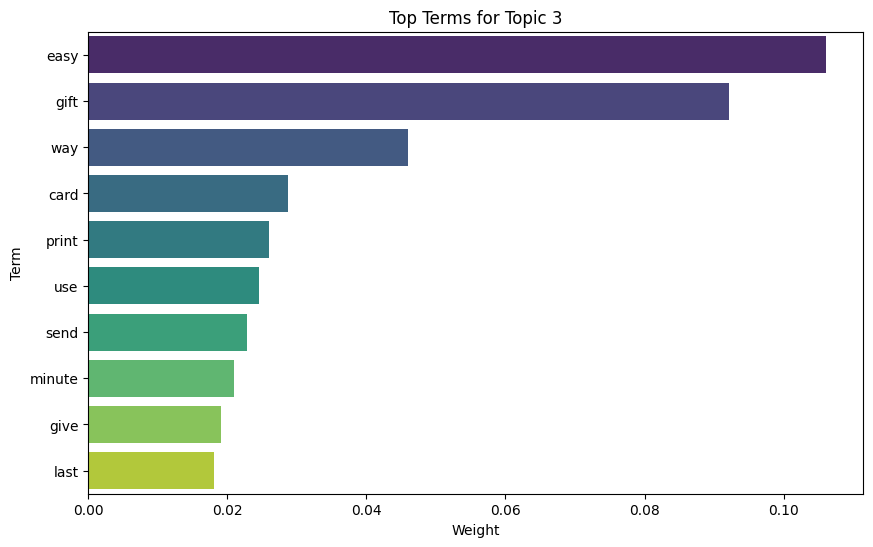

C:\Users\v-collinstoo\AppData\Local\Temp\ipykernel_5044\4048692238.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette='viridis')


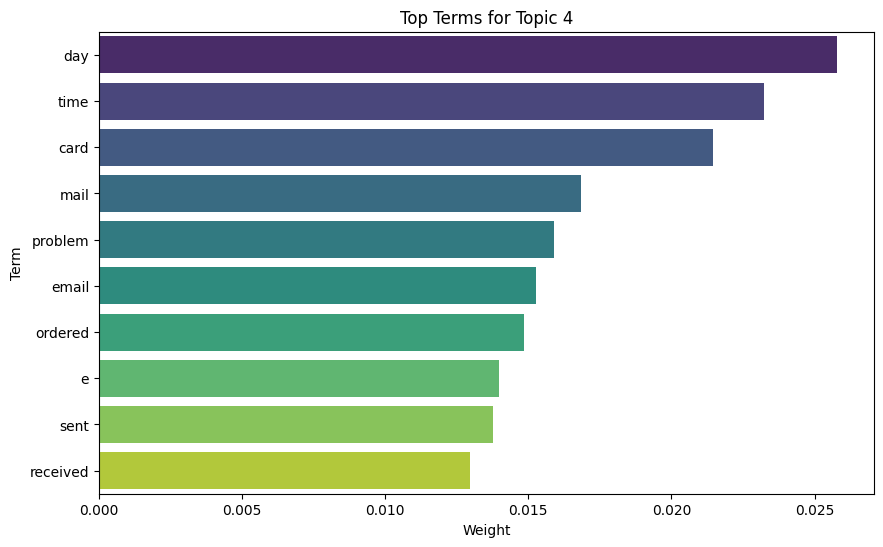

In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import download
from gensim import corpora, models
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Ensure necessary NLTK data is downloaded
download('stopwords')
download('wordnet')

def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    root.attributes('-topmost', True)  # Ensure root window is on top
    file_paths = filedialog.askopenfilenames(parent=root)
    if file_paths:
        for file_path in file_paths:
            process_file(file_path)

def load_data(file_path):
    return pd.read_csv(file_path, sep='\t', on_bad_lines='skip')

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    stop_words = set(stopwords.words('english')) | {'br'}
    words = text.split()
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

def process_file(file_path):
    df = load_data(file_path)
    df = df[['review_body']].dropna()
    df['cleaned_review'] = df['review_body'].apply(preprocess_text)

    text_data = [text.split() for text in df['cleaned_review']]
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]

    num_topics = 5
    ldamodel = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1)
    topics = ldamodel.print_topics(num_words=4)
    for topic in topics:
        print(topic)

    # Dictionary to store word count by topic
    topic_word_counts = {i: [] for i in range(num_topics)}

    # Process each document to determine dominant topic and word count
    for doc_id, doc in enumerate(corpus):
        doc_topics = ldamodel.get_document_topics(doc, minimum_probability=0)
        doc_topics = sorted(doc_topics, key=lambda x: -x[1])
        dominant_topic, _ = doc_topics[0]
        word_count = len(text_data[doc_id])
        topic_word_counts[dominant_topic].append(word_count)

    # Generate and display word clouds for each topic
    for i in range(num_topics):
        topic_words = dict(ldamodel.show_topic(i, 200))
        wordcloud = WordCloud(width=400, height=400,
                              background_color='white',
                              stopwords=stopwords.words('english'),
                              min_font_size=10).generate_from_frequencies(topic_words)

        plt.figure(figsize=(5, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {i}")
        plt.show()

    # Plot distribution of word counts by dominant topic
    for i in range(num_topics):
        plt.figure(figsize=(10, 6))
        sns.histplot(topic_word_counts[i], bins=30, kde=True, color='skyblue')
        plt.title(f'Distribution of Document Word Counts for Topic {i}')
        plt.xlabel('Word Count')
        plt.ylabel('Number of Documents')
        plt.show()

    # Plot topic distribution across all documents
    topic_distribution = [max(ldamodel[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]
    sns.histplot(topic_distribution, bins=num_topics, kde=False, discrete=True)
    plt.title('Topic Distribution Across All Documents')
    plt.xlabel('Topic')
    plt.ylabel('Number of Documents')
    plt.xticks(range(num_topics))
    plt.show()

    # Coherence scores for different numbers of topics
    coherence_values = []
    topic_range = range(2, 10)
    for num in topic_range:
        model = models.LdaModel(corpus, num_topics=num, id2word=dictionary, passes=1)
        coherence_model = CoherenceModel(model=model, texts=text_data, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    plt.figure(figsize=(10, 6))
    plt.plot(topic_range, coherence_values, marker='o')
    plt.title('Coherence Scores by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(topic_range)
    plt.show()

    # Compute and visualize TF-IDF heatmap
    cleaned_reviews = df['cleaned_review'].tolist()
    vectorizer = TfidfVectorizer(max_features=50)
    tfidf_matrix = vectorizer.fit_transform(cleaned_reviews).toarray()
    terms = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(tfidf_matrix, columns=terms)

    plt.figure(figsize=(12, 8))
    sns.heatmap(tfidf_df.T, cmap='YlGnBu', cbar=True)
    plt.title('TF-IDF Scores for Top 50 Terms')
    plt.xlabel('Document Index')
    plt.ylabel('Term')
    plt.show()

    # Bar plot of top terms for each topic
    for i in range(num_topics):
        topic_words = ldamodel.show_topic(i, 10)
        words = [word for word, _ in topic_words]
        weights = [weight for _, weight in topic_words]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=weights, y=words, palette='viridis')
        plt.title(f'Top Terms for Topic {i}')
        plt.xlabel('Weight')
        plt.ylabel('Term')
        plt.show()

# Call the select_file function to trigger the file selection dialog
select_file()
